# UD2.2 Problem 3

### Student: Fernando Soto

## The Prime State

$\renewcommand{\ket}[1]{\left| #1 \right\rangle}$

Counting the number of prime numbers

$$\ket{P(n)}=\frac{1}{\sqrt(\pi(2^n))}\sum_{p<2^n \in Primes}\ket{p}$$

A Qiskit circuit can be built to generate a superposition of all prime numbers between 0 and N = 2^n where n is the number of bits

     ┌──────────────────────────────────────┐┌─┐      
q_0: ┤0                                     ├┤M├──────
     │                                      │└╥┘┌─┐   
q_1: ┤1 Initialize(0,0,0.5,0.5,0,0.5,0,0.5) ├─╫─┤M├───
     │                                      │ ║ └╥┘┌─┐
q_2: ┤2                                     ├─╫──╫─┤M├
     └──────────────────────────────────────┘ ║  ║ └╥┘
c: 3/═════════════════════════════════════════╩══╩══╩═
                                              0  1  2 


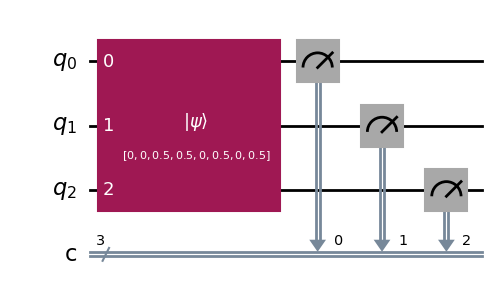

In [1]:
from qiskit import QuantumCircuit
from sympy import primerange
import numpy as np

def prime_superposition(n: int) -> QuantumCircuit:
    """
    Generate a quantum circuit preparing |P(n)> =
    1/sqrt(pi(2^n)) sum_{p < 2^n, p prime} |p>.
    
    Args:
        n (int): number of qubits
    
    Returns:
        QuantumCircuit: circuit that initializes the prime superposition state
    """
    dim = 2**n
    
    # Find primes less than 2^n
    primes = list(primerange(0, dim))
    num_primes = len(primes)
    
    # Build statevector
    state = np.zeros(dim, dtype=complex)
    for p in primes:
        state[p] = 1/np.sqrt(num_primes)
    
    # Create circuit with n qubits and n classical bits
    qc = QuantumCircuit(n, n)
    
    # Initialize to prime superposition
    qc.initialize(state, list(range(n)))
    
    # Add measurements: each qubit → corresponding classical bit
    qc.measure(range(n), range(n))
    
    return qc

qc = prime_superposition(3)   # 3 qubits → primes < 8
print(qc)
qc.draw("mpl")

Now we generate superpositions for n=3 and n=4 and run them in IBM Quantum backend

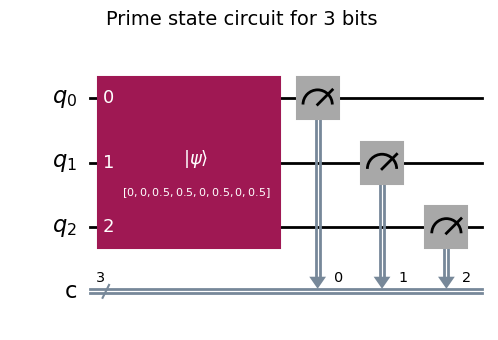

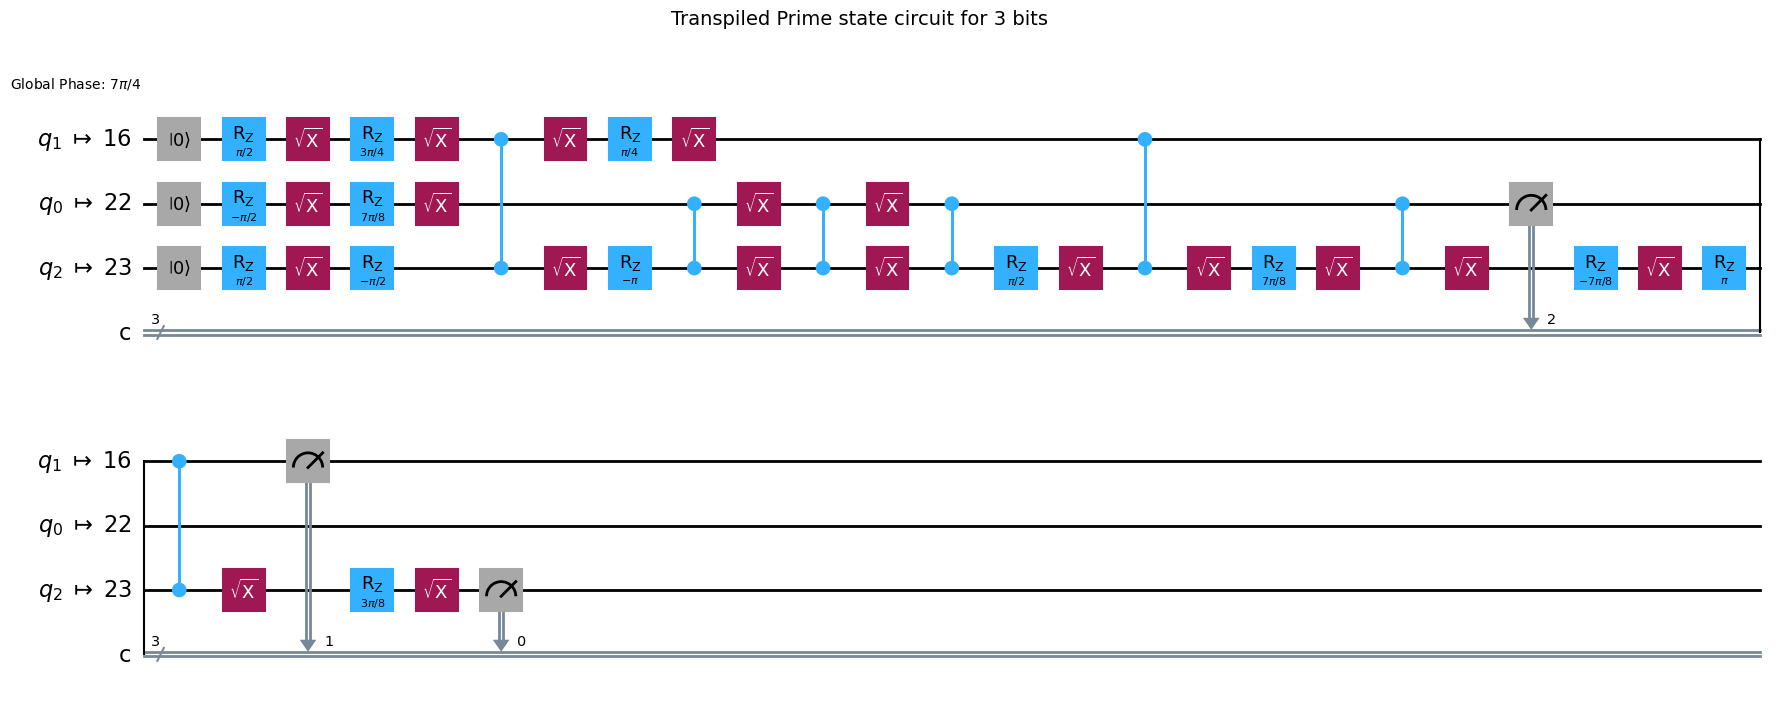

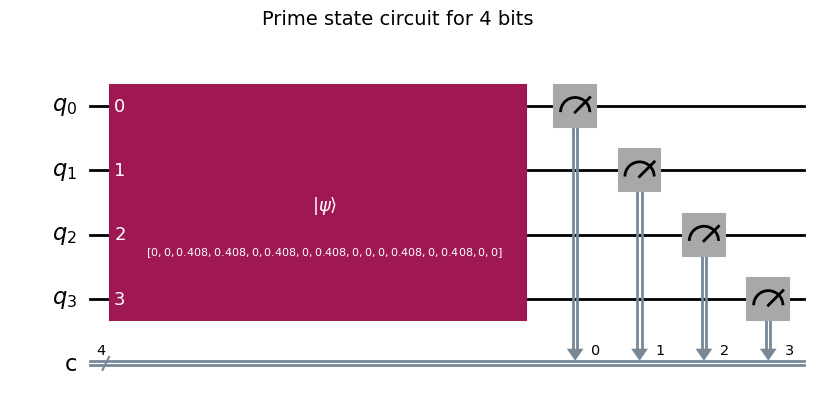

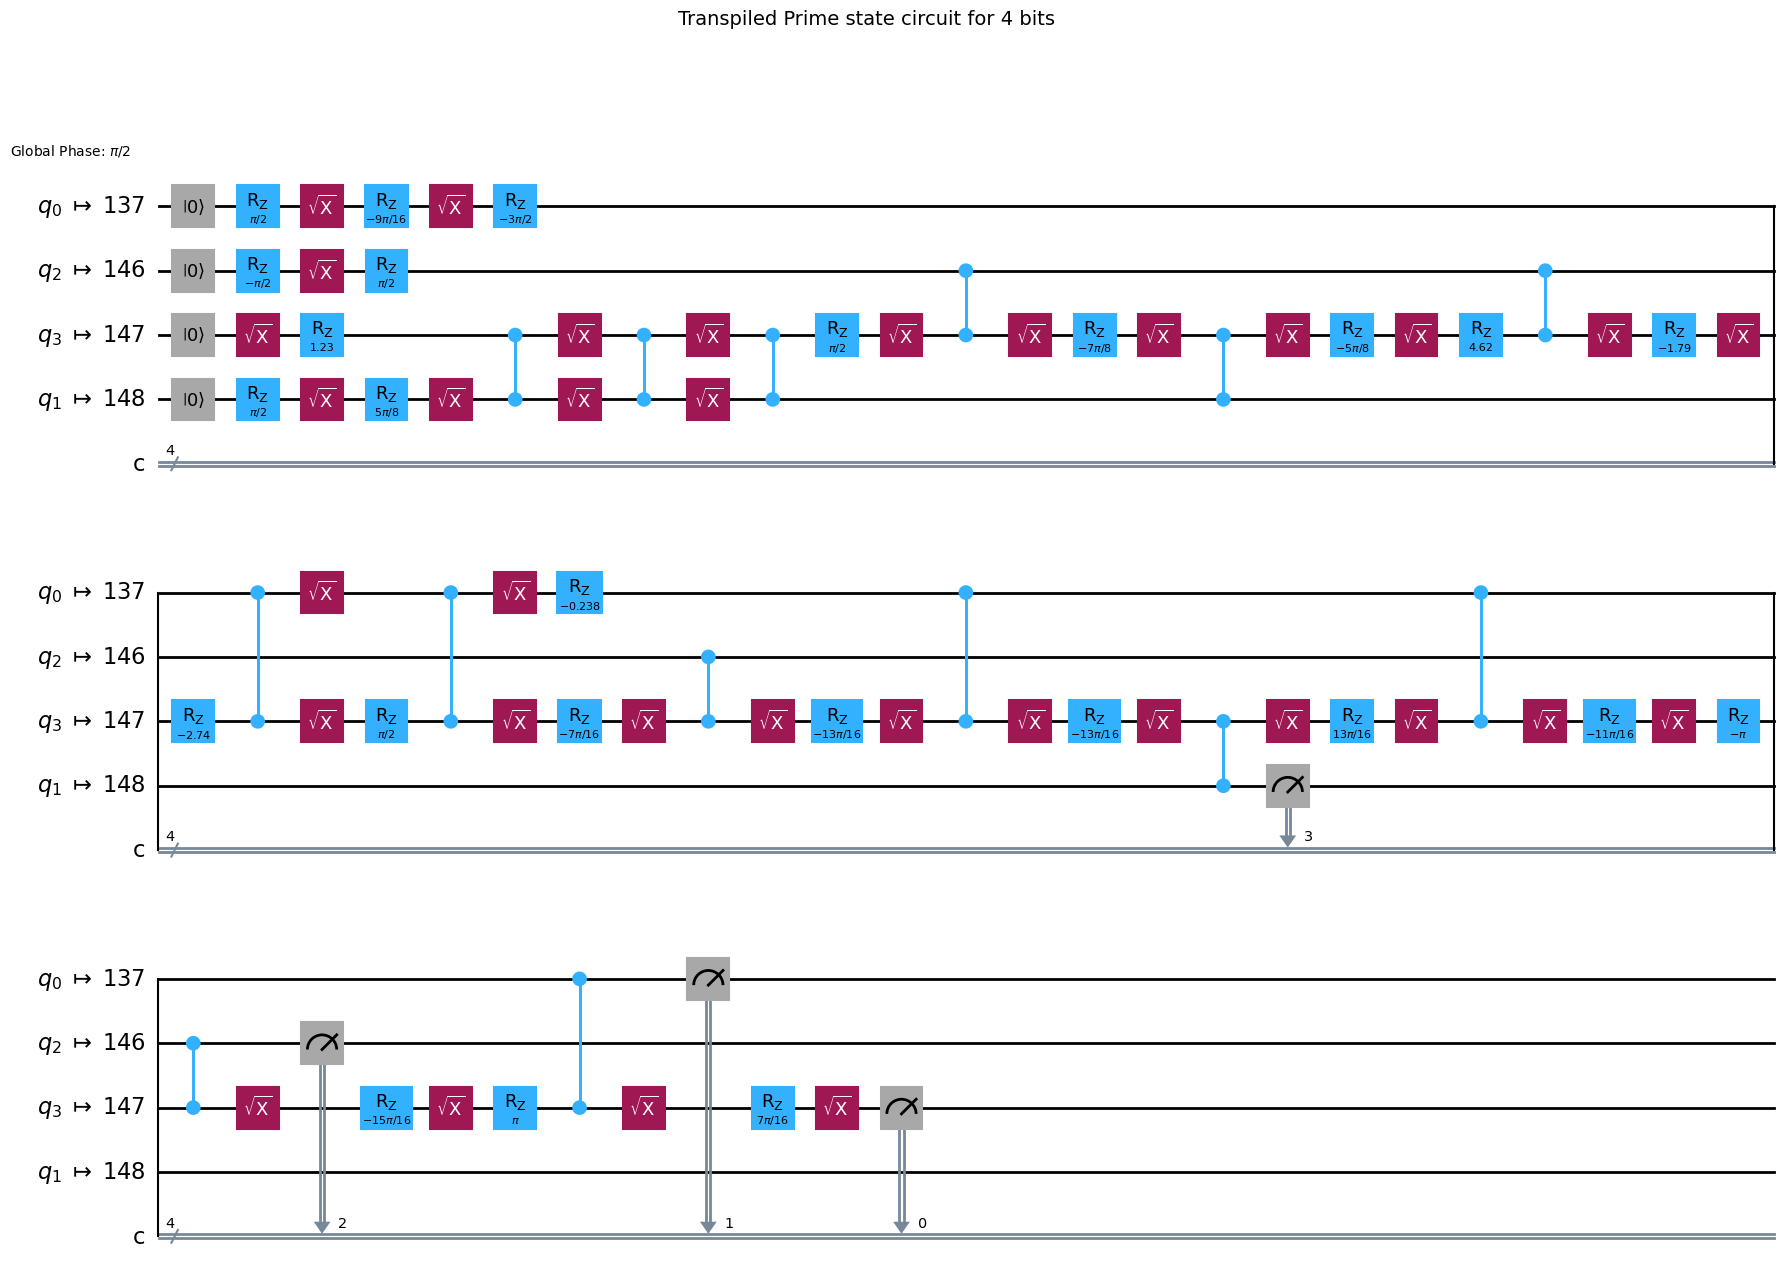

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.visualization import plot_histogram
from qiskit import transpile
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# Load service
service = QiskitRuntimeService()

backend = service.backend("ibm_fez") 

inputs = [3, 4]
job_ids = {}

for n in inputs:
    qc = prime_superposition(n)
    # Transpile
    qc_t = transpile(qc, backend)
    # Run
    sampler = SamplerV2(mode=backend)
    # Submit to IBM Quantum backend
    job = sampler.run([qc_t], shots=1024)
    job_ids[n]= job.job_id()
    fig_c = qc.draw("mpl")   # matplotlib output
    fig_c.suptitle(f"Prime state circuit for {n} bits", fontsize=14)
    fig_tc = qc_t.draw("mpl")   # matplotlib output
    fig_tc.suptitle(f"Transpiled Prime state circuit for {n} bits", fontsize=14)

And we can now display the results from the backend 

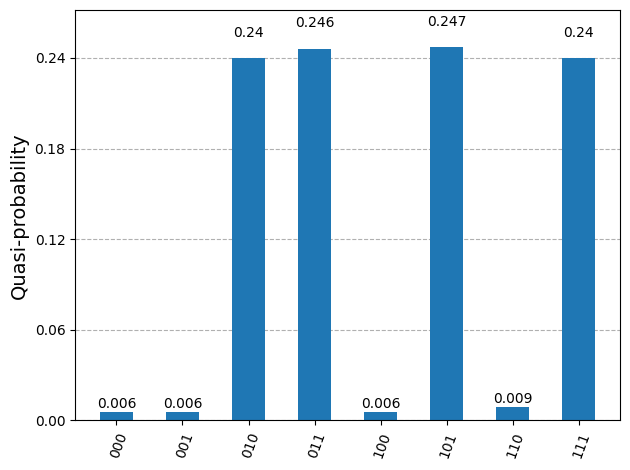

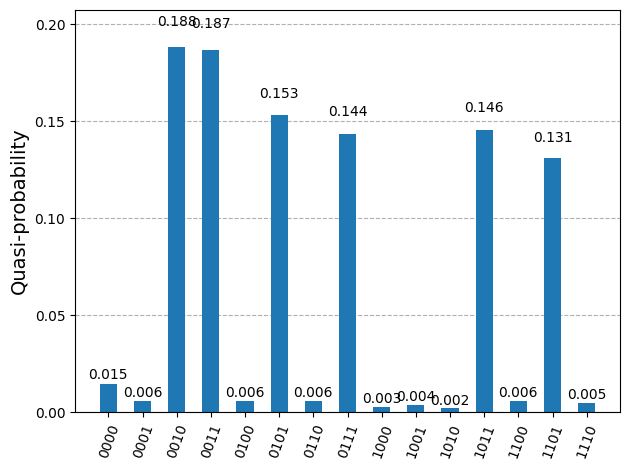

In [ ]:
import numpy as np
%matplotlib inline

def display_job_result(job_result):
    # Each pub result is in result[0], result[1], ...
    pub_result = job_result[0]
    datab = pub_result.data

    # Get the BitArray for the first register
    bitarray = list(datab.values())[0]

    arr = bitarray.array   # raw numpy array of dtype=uint8
    num_bits = bitarray.num_bits

    samples = []
    for shot in arr:
        bits = np.unpackbits(shot, bitorder="little")[:num_bits]
        # Reverse endianness here
        samples.append("".join(str(b) for b in bits[::-1]))

    counts = Counter(samples)

    # Normalize to probabilities
    total_shots = sum(counts.values())
    probabilities = {state: freq/total_shots for state, freq in counts.items()}

    fig = plot_histogram(probabilities)
    plt.show()
    return fig

for n in inputs:   
    job = service.job(job_ids[n])
    job_result = job.result()
    fig = display_job_result(job_result)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # reserve top 5% for suptitle
    fig.suptitle(f"Prime State for {n} bits")


In [ ]:
pub_result = job_result[0]
print(dir(pub_result.data))